In [28]:
using Plots
using Statistics
using JLD2
using Base.Threads
using ITensors
using Distributions, Random
using StatsBase:kldivergence
using StatsBase:sample
include("../utils.jl");

In [3]:
mps0 = load_mps_from_h5("mps0_10000.h5","mps0_10000");
mps1 = load_mps_from_h5("mps1_10000.h5","mps1_10000");

In [4]:
@load "X_train_10000.jld2"

2-element Vector{Symbol}:
 :X_train_scaled
 :y_train

In [5]:
class_0_idxs = findall(x -> x .== 0, y_train);
class_1_idxs = findall(x -> x .== 1, y_train);

In [6]:
class_0_samples = X_train_scaled[class_0_idxs, :]
class_1_samples = X_train_scaled[class_1_idxs, :];

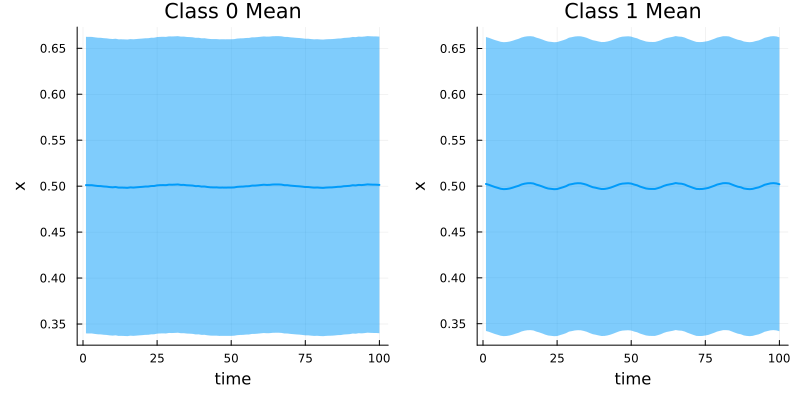

In [31]:
p1 = plot(mean(class_0_samples, dims=1)[1, :], ribbon=std(class_0_samples, dims=1),label="", xlabel="time", ylabel="x", title="Class 0 Mean", lw=2)
p2 = plot(mean(class_1_samples, dims=1)[1, :], ribbon=std(class_1_samples, dims=1),label="", xlabel="time", ylabel="x", title="Class 1 Mean", lw=2)
plot(p1, p2, size=(800,400), left_margin=5mm, bottom_margin=5mm)

In [3]:
mps0_copy = deepcopy(mps0);
mps1_copy = deepcopy(mps1);

In [153]:
samps0 = Matrix{Float64}(undef, 5000, 100);
samps1 = Matrix{Float64}(undef, 5000, 100);
@threads for i in 1:5000
    samp0 = generate_sample(deepcopy(mps0_copy); dx=0.1)
    samp1 = generate_sample(deepcopy(mps1_copy); dx=0.1)
    samps0[i, :] = samp0
    samps1[i, :] = samp1
end

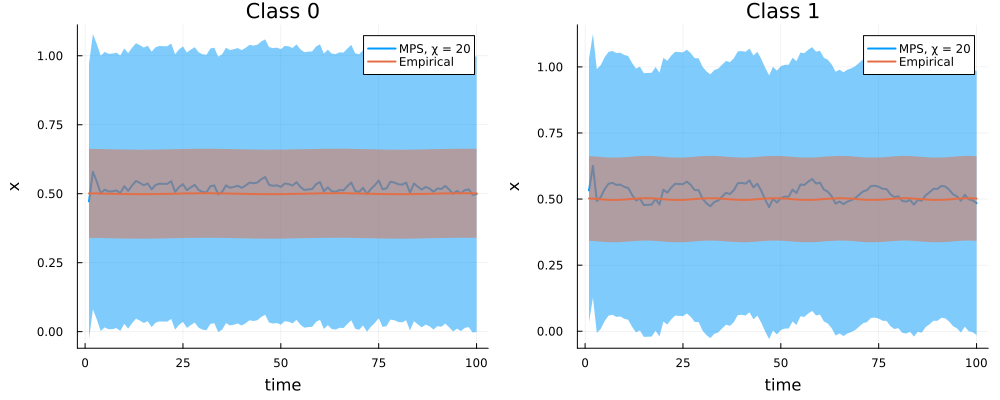

In [152]:
p = plot(mean(samps0, dims=1)[1,:], lw=2, ribbon=std(samps0, dims=1), title="Class 0", xlabel="time", ylabel="x", label="MPS, χ = 20")
plot!(mean(class_0_samples, dims=1)[1,:], lw=2, ribbon=std(class_0_samples, dims=1), label="Empirical")

p2 = plot(mean(samps1, dims=1)[1,:], lw=2, ribbon=std(samps1, dims=1), title="Class 1", xlabel="time", ylabel="x", label="MPS, χ = 20")
plot!(mean(class_1_samples, dims=1)[1,:], lw=2, ribbon=std(class_1_samples, dims=1), label="Empirical")
plot(p, p2, size=(1000,400), bottom_margin=5mm, left_margin=5mm)
#savefig("empirical_versus_mps_chi20.svg")

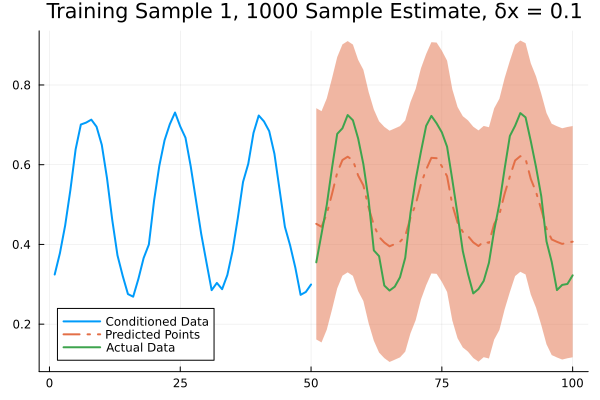

In [91]:
plot(collect(1:50), class_1_samples[1,1:50], lw=2, label="Conditioned Data", title="Training Sample 1, 1000 Sample Estimate, δx = 0.1", legend=:bottomleft)
plot!(collect(51:100), mean(interp_samps1000, dims=1)[1,:], ribbon=std(interp_samps1000, dims=1), label="Predicted Points", ls=:dashdot, lw=2)
plot!(collect(51:100), class_1_samples[1, 51:100], label="Actual Data", lw=2)
#savefig("training_sample_class_1.svg")

In [92]:
interp2_samps1000 = Matrix{Float64}(undef, 1000, 50);
@threads for i in 1:1000
    samp = interpolate_sample(deepcopy(mps1), class_1_samples[500,1:50], 51; dx=0.1);
    interp2_samps1000[i, :] = samp
end

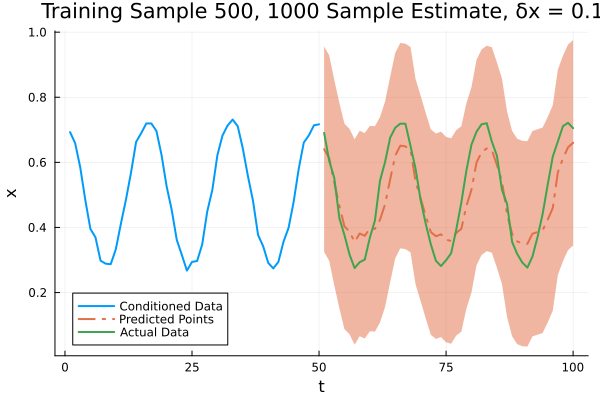

In [100]:
plot(collect(1:50), class_1_samples[500,1:50], lw=2, label="Conditioned Data", title="Training Sample 500, 1000 Sample Estimate, δx = 0.1", legend=:bottomleft)
plot!(collect(51:100), mean(interp2_samps1000, dims=1)[1,:], ribbon=std(interp2_samps1000, dims=1), label="Predicted Points", ls=:dashdot, lw=2)
plot!(collect(51:100), class_1_samples[500, 51:100], label="Actual Data", lw=2)
xlabel!("t")
ylabel!("x")
#savefig("training_sample500_class_1.svg")

Now let's look at some testing data:

In [7]:
@load "X_test_10000.jld2"

2-element Vector{Symbol}:
 :X_test_scaled
 :y_test

In [8]:
class_0_test_idxs = findall(x -> x .== 0, y_test);
class_1_test_idxs = findall(x -> x .== 1, y_test);

In [9]:
class_0_test_samples = X_test_scaled[class_0_test_idxs, :]
class_1_test_samples = X_test_scaled[class_1_test_idxs, :];

In [109]:
interp3_samps1000 = Matrix{Float64}(undef, 1000, 50);
@threads for i in 1:1000
    samp = interpolate_sample(deepcopy(mps1), class_1_test_samples[1,1:50], 51; dx=0.1);
    interp3_samps1000[i, :] = samp
end

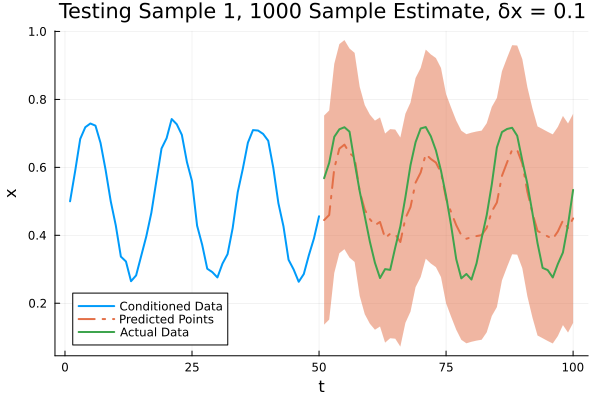

In [114]:
plot(collect(1:50), class_1_test_samples[1,1:50], lw=2, label="Conditioned Data", title="Testing Sample 1, 1000 Sample Estimate, δx = 0.1", legend=:bottomleft)
plot!(collect(51:100), mean(interp3_samps1000, dims=1)[1,:], ribbon=std(interp3_samps1000, dims=1), label="Predicted Points", ls=:dashdot, lw=2)
plot!(collect(51:100), class_1_test_samples[1, 51:100], label="Actual Data", lw=2)
xlabel!("t")
ylabel!("x")
#savefig("testing_sample_1_class1.svg")

In [125]:
interp4_samps1000 = Matrix{Float64}(undef, 5000, 50);
@threads for i in 1:5000
    samp = interpolate_sample(deepcopy(mps1), class_1_test_samples[155,1:50], 51; dx=1.0);
    interp4_samps1000[i, :] = samp
end

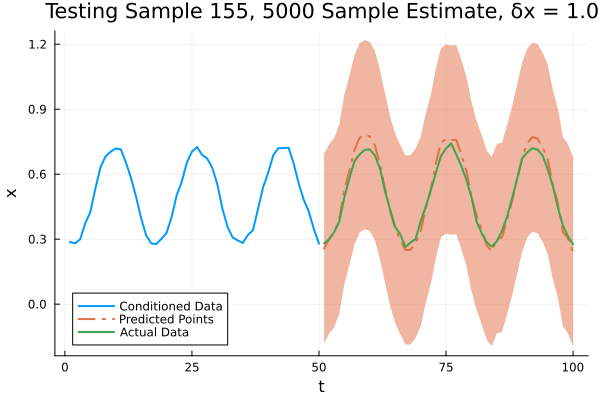

In [132]:
plot(collect(1:50), class_1_test_samples[155,1:50], lw=2, label="Conditioned Data", title="Testing Sample 155, 5000 Sample Estimate, δx = 1.0", legend=:bottomleft)
plot!(collect(51:100), mean(interp4_samps1000, dims=1)[1,:], ribbon=std(interp4_samps1000, dims=1), label="Predicted Points", ls=:dashdot, lw=2)
plot!(collect(51:100), class_1_test_samples[155, 51:100], label="Actual Data", lw=2)
xlabel!("t")
ylabel!("x")
#savefig("testing_sample_155_class1_dx1.svg")

In [133]:
interp5_samps5000 = Matrix{Float64}(undef, 5000, 50);
@threads for i in 1:5000
    samp = interpolate_sample(deepcopy(mps1), class_1_test_samples[1,1:50], 51; dx=1.0);
    interp5_samps5000[i, :] = samp
end

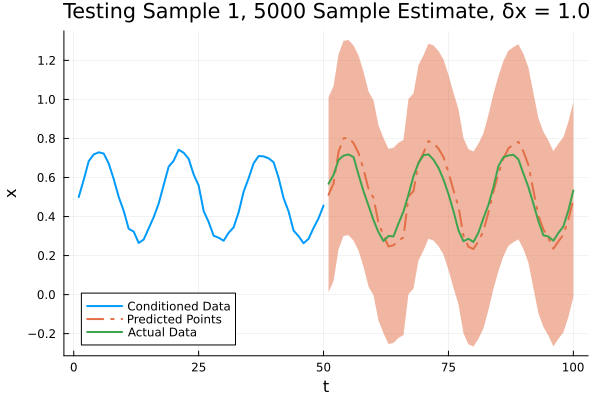

In [186]:
plot(collect(1:50), class_1_test_samples[1,1:50], lw=2, label="Conditioned Data", title="Testing Sample 1, 5000 Sample Estimate, δx = 1.0", legend=:bottomleft)
plot!(collect(51:100), mean(interp5_samps5000, dims=1)[1,:], ribbon=std(interp5_samps5000, dims=1), label="Predicted Points", ls=:dashdot, lw=2)
plot!(collect(51:100), class_1_test_samples[1, 51:100], label="Actual Data", lw=2)
xlabel!("t")
ylabel!("x")
#savefig("testing_sample_1_class1_dx1.svg")

In [156]:
interp3_samps100_000 = Matrix{Float64}(undef, 100_000, 50);
@threads for i in 1:100_000
    samp = interpolate_sample(deepcopy(mps1), class_1_test_samples[1,1:50], 51; dx=0.1);
    interp3_samps100_000[i, :] = samp
end

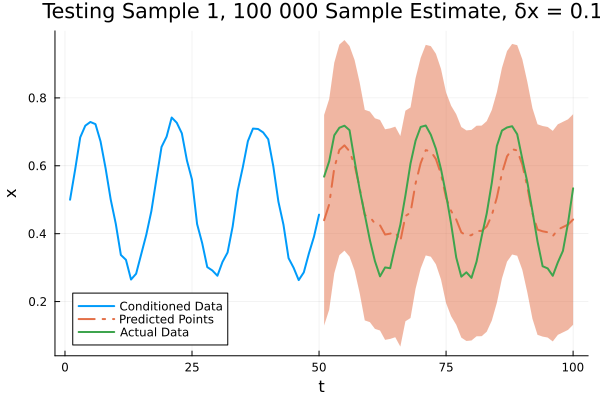

In [161]:
plot(collect(1:50), class_1_test_samples[1,1:50], lw=2, label="Conditioned Data", title="Testing Sample 1, 100 000 Sample Estimate, δx = 0.1", legend=:bottomleft)
plot!(collect(51:100), mean(interp3_samps100_000, dims=1)[1,:], ribbon=std(interp3_samps100_000, dims=1), label="Predicted Points", ls=:dashdot, lw=2)
plot!(collect(51:100), class_1_test_samples[1, 51:100], label="Actual Data", lw=2)
xlabel!("t")
ylabel!("x")

Compute Symmetric Mean Absolute Percentage Error (SMAPE)

In [29]:
function compute_smape(forecasted::Vector{Float64}, actual::Vector{Float64})
    @assert length(forecasted) == length(actual) "Time series lengths do not match"
    """Compute SMAPE (Symmetric Mean Absolute Percentage Error)"""
    abs_diff = abs.(forecasted .- actual)
    sum_abs_vals = abs.(actual) .+ abs.(forecasted)
    smape = mean(200*(abs_diff/sum_abs_vals))
    return smape
    
end

compute_smape (generic function with 1 method)

In [29]:
sms = []
num_samps = [500, 1000, 5000, 10_000, 20_000]
for samp_num in num_samps 
    interp_samps_new = Matrix{Float64}(undef, samp_num, 50)
    @threads for i in 1:samp_num
        samp = interpolate_sample(deepcopy(mps1), class_1_test_samples[25,1:50], 51; dx=1.0);
        interp_samps_new[i, :] = samp
    end
    smape_val = compute_smape(mean(interp_samps_new, dims=1)[1,:], class_1_test_samples[25,51:end])
    println(smape_val)
    push!(sms, smape_val)
end

0.11085028132338427
0.08312877068299754
0.08669026052620853
0.08326463774557363
0.08653925622034137


In [20]:
interp_samps_new = Matrix{Float64}(undef, 1000, 50);
@threads for i in 1:1000
    samp = interpolate_sample(deepcopy(mps1), class_1_test_samples[25,1:50], 51; dx=1.0);
    interp_samps_new[i, :] = samp
end

In [21]:
compute_smape(mean(interp_samps_new, dims=1)[1,:], class_1_test_samples[25,51:end])

0.08130848248642811

# Compute sMAPE for all Class 1 test samples

In [38]:
smapes_all_c1 = []
samps_idxs = sample(collect(1:size(class_1_test_samples)[1]), 150; replace=false)
for i in samps_idxs
    # get the sample and slice into 50% conditioning and 50% testing
    ground_truth_sample = class_1_test_samples[i,1:50]
    interp_samps = Matrix{Float64}(undef, 1000, 50);
    @threads for j in 1:1000
        samp = interpolate_sample(deepcopy(mps1), ground_truth_sample, 51; dx=1.0);
        interp_samps[j, :] = samp
    end
    predicted_sample = mean(interp_samps, dims=1)[1,:]
    # compute smape between forecasted and actual
    # actual 
    ground_truth_actual = class_1_test_samples[i,51:end]
    sm = compute_smape(predicted_sample, ground_truth_actual)
    push!(smapes_all_c1, sm)
    println("Sample $i : sMAPE: $sm")
end

Sample 204 : sMAPE: 0.171756578359546
Sample 149 : sMAPE: 0.13619108329944354
Sample 63 : sMAPE: 0.1699719717180857
Sample 57 : sMAPE: 0.26360712333010905
Sample 282 : sMAPE: 0.15761708518709358
Sample 395 : sMAPE: 0.08177015428897477
Sample 173 : sMAPE: 0.14479914909822625
Sample 220 : sMAPE: 0.14151222261861818
Sample 299 : sMAPE: 0.13152315154585006
Sample 60 : sMAPE: 0.07954606272234165
Sample 462 : sMAPE: 0.19435393968116527
Sample 18 : sMAPE: 0.2818223450742975
Sample 153 : sMAPE: 0.15299141196816746
Sample 226 : sMAPE: 0.11138290265497153
Sample 388 : sMAPE: 0.16569395193461472
Sample 172 : sMAPE: 0.1890699601725385
Sample 399 : sMAPE: 0.12961210287823544
Sample 194 : sMAPE: 0.21728364242676634
Sample 377 : sMAPE: 0.0998606546982734
Sample 201 : sMAPE: 0.17147678319573748
Sample 412 : sMAPE: 0.11514527414071565
Sample 91 : sMAPE: 0.1032410504311349
Sample 441 : sMAPE: 0.2580063905414812
Sample 106 : sMAPE: 0.156328086740555
Sample 244 : sMAPE: 0.1495928417461035
Sample 435 : sMA

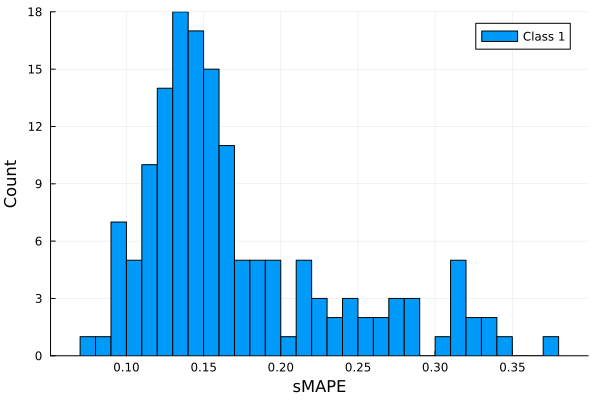

In [42]:
histogram(smapes_all_c1, bins=50, xlabel="sMAPE", ylabel="Count", label="Class 1")

----

# Class 0

In [10]:
size(class_0_test_samples)[1]

523

Compute the sMAPE for a subset of 100 random samples

In [24]:
smapes_all = []
samps_idxs = sample(collect(1:size(class_0_test_samples)[1]), 150; replace=false)
for i in samps_idxs
    # get the sample and slice into 50% conditioning and 50% testing
    ground_truth_sample = class_0_test_samples[i,1:50]
    interp_samps = Matrix{Float64}(undef, 1000, 50);
    @threads for j in 1:1000
        samp = interpolate_sample(deepcopy(mps0), ground_truth_sample, 51; dx=1.0);
        interp_samps[j, :] = samp
    end
    predicted_sample = mean(interp_samps, dims=1)[1,:]
    ground_truth_actual = class_0_test_samples[i,51:end]
    sm = compute_smape(predicted_sample, ground_truth_actual)
    push!(smapes_all, sm)
    println("Sample $i : sMAPE: $sm")
end

Sample 87 : sMAPE: 0.1983681284606827
Sample 128 : sMAPE: 0.18870014891727988
Sample 65 : sMAPE: 0.3486762513127253
Sample 100 : sMAPE: 0.3030631163167277
Sample 59 : sMAPE: 0.9658546879336777
Sample 5 : sMAPE: 0.21934427093809528
Sample 379 : sMAPE: 0.16379562164411549
Sample 233 : sMAPE: 0.1439577921249936
Sample 462 : sMAPE: 0.13013636267760637
Sample 320 : sMAPE: 0.1258344297093977
Sample 131 : sMAPE: 0.2895129118546446
Sample 192 : sMAPE: 0.25857709525106265
Sample 293 : sMAPE: 0.22758283768149531
Sample 455 : sMAPE: 0.2402679446026569
Sample 23 : sMAPE: 0.21264804285105343
Sample 402 : sMAPE: 0.17927465170035575
Sample 80 : sMAPE: 0.2635351970462405
Sample 519 : sMAPE: 0.12412343678028355
Sample 76 : sMAPE: 0.14893535299458058
Sample 278 : sMAPE: 0.735353488721022
Sample 179 : sMAPE: 0.13670449884679747
Sample 36 : sMAPE: 0.4783498146124284
Sample 450 : sMAPE: 0.8057767385164903
Sample 375 : sMAPE: 0.9413919851870847
Sample 243 : sMAPE: 0.6828201501861482
Sample 438 : sMAPE: 0.30

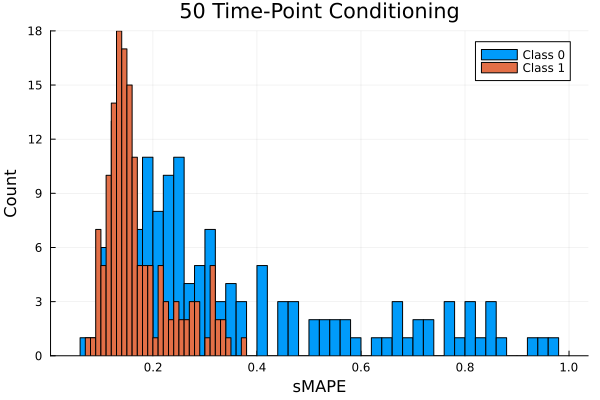

In [52]:
histogram(smapes_all, bins=50, xlabel="sMAPE", ylabel="Count", label="Class 0")
histogram!(smapes_all_c1, bins=50, label="Class 1")
title!("50 Time-Point Conditioning")
#savefig("forecasting_performance_hist.svg")

In [53]:
using StatsPlots

In [32]:
violin(smapes_all, ylabel="sMAPE", label="")
violin!(smapes_all_c1, label="")
class_names = ["Class 0", "Class 1"]
xticks!(1:2, class_names,)
title!("50 Time-Point Conditioning")
#savefig("forecasting_performance_violin.svg")

UndefVarError: UndefVarError: `smapes_all` not defined

In [80]:
interp_samps = Matrix{Float64}(undef, 1000, 50);
@threads for j in 1:1000
    samp = interpolate_sample(deepcopy(mps0), class_0_test_samples[57,1:50], 51; dx=1.0);
    interp_samps[j, :] = samp
end

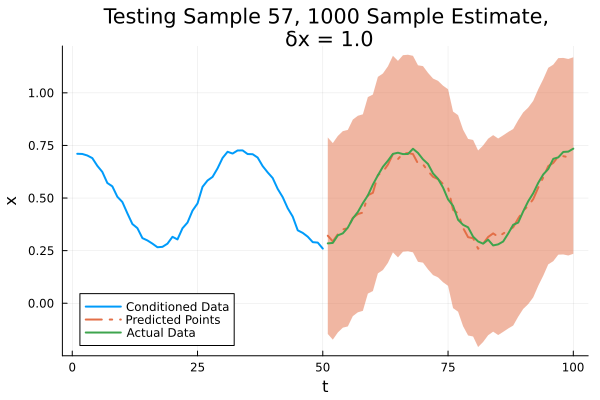

In [74]:
plot(collect(1:50), class_0_test_samples[57,1:50], lw=2, label="Conditioned Data", title="Testing Sample 57, 1000 Sample Estimate,\n δx = 1.0" , legend=:bottomleft)
plot!(collect(51:100), mean(interp_samps, dims=1)[1,:], ribbon=std(interp_samps, dims=1), label="Predicted Points", ls=:dashdot, lw=2)
plot!(collect(51:100), class_0_test_samples[57, 51:100], label="Actual Data", lw=2)
xlabel!("t")
ylabel!("x")
#savefig("test_sample_57_class0_dx1.svg")

In [75]:
interp_samps = Matrix{Float64}(undef, 1000, 50);
@threads for j in 1:1000
    samp = interpolate_sample(deepcopy(mps0), class_0_test_samples[459,1:50], 51; dx=1.0);
    interp_samps[j, :] = samp
end

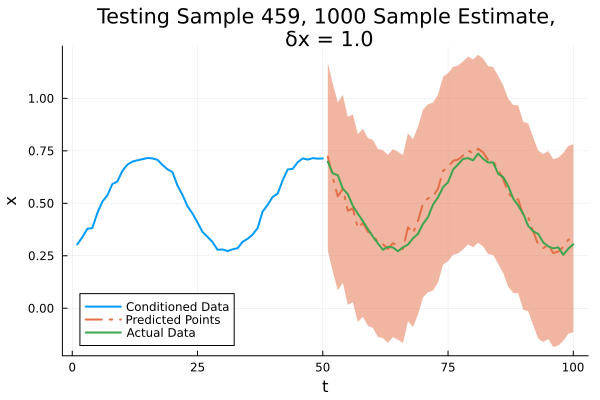

In [78]:
plot(collect(1:50), class_0_test_samples[459,1:50], lw=2, label="Conditioned Data", title="Testing Sample 459, 1000 Sample Estimate,\n δx = 1.0" , legend=:bottomleft)
plot!(collect(51:100), mean(interp_samps, dims=1)[1,:], ribbon=std(interp_samps, dims=1), label="Predicted Points", ls=:dashdot, lw=2)
plot!(collect(51:100), class_0_test_samples[459, 51:100], label="Actual Data", lw=2)
xlabel!("t")
ylabel!("x")
#savefig("test_sample_459_class0_dx1.svg")

In [87]:
interp_samps = Matrix{Float64}(undef, 1000, 50);
@threads for j in 1:1000
    samp = interpolate_sample(deepcopy(mps0), class_0_test_samples[156,1:50], 51; dx=1.0);
    interp_samps[j, :] = samp
end

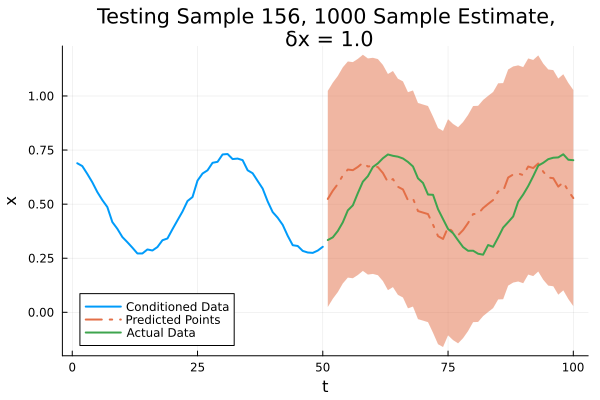

In [90]:
plot(collect(1:50), class_0_test_samples[156,1:50], lw=2, label="Conditioned Data", title="Testing Sample 156, 1000 Sample Estimate,\n δx = 1.0" , legend=:bottomleft)
plot!(collect(51:100), mean(interp_samps, dims=1)[1,:], ribbon=std(interp_samps, dims=1), label="Predicted Points", ls=:dashdot, lw=2)
plot!(collect(51:100), class_0_test_samples[156, 51:100], label="Actual Data", lw=2)
xlabel!("t")
ylabel!("x")
#savefig("test_sample_156_class0_dx1.svg")

In [95]:
interp_samps = Matrix{Float64}(undef, 1000, 50);
@threads for j in 1:1000
    samp = interpolate_sample(deepcopy(mps0), class_0_test_samples[165,1:50], 51; dx=1.0);
    interp_samps[j, :] = samp
end

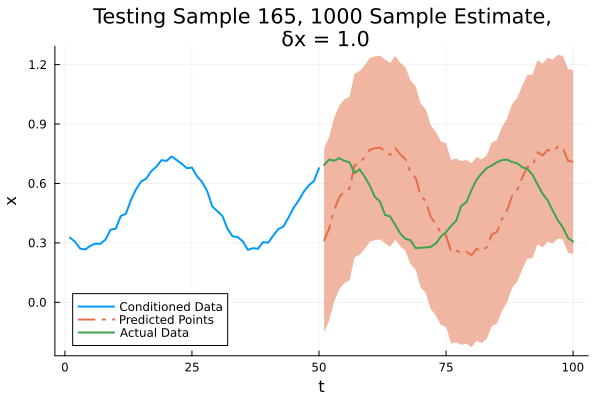

In [98]:
plot(collect(1:50), class_0_test_samples[165,1:50], lw=2, label="Conditioned Data", title="Testing Sample 165, 1000 Sample Estimate,\n δx = 1.0" , legend=:bottomleft)
plot!(collect(51:100), mean(interp_samps, dims=1)[1,:], ribbon=std(interp_samps, dims=1), label="Predicted Points", ls=:dashdot, lw=2)
plot!(collect(51:100), class_0_test_samples[165, 51:100], label="Actual Data", lw=2)
xlabel!("t")
ylabel!("x")
#savefig("test_sample_165_class0_dx1.svg")